# Examining Parietal Contributions to Object Recognition
## Max Kramer, Behrmann Lab
Final project, Data Science for Psychology and Neuroscience, Fall 2023
Prof. Tim Verstynen, TA Fiona Horner

---

### 1. Background

Neuroscientists have worked for decades to understand how our cognitive abilities are realized in the brain. In the domain of vision science, one major discovery suggested that the visual system is organized along two processing streams: a dorsal stream that enables our abilities to locate and interact with objects in the world around us, and a ventral stream that enables our extraordinary recognition abilities (Mishkin et al., 1983; Ungerleider & Haxby, 1994). This 'two streams' hypothesis has been the prevailing model of the visual system for many years, but recent results suggesting that posterior parietal cortex (PPC), a region in the dorsal stream may compute object features relevant to recognition (Bracci & Op de Beeck, 2016; Freud et al., 2017) has called the separation of these streams into question.

One recent study put forward the hypothesis that areas in the dorsal stream may compute the spatial relations between an object's component parts, helping to subserve object recognition (Ayzenberg & Berhmann, 2022). One key result from Ayzenberg and Behrmann's analysis was that activity in dorsal cortex could be used to decode object category at levels similar to traditionally examined ventral cortical areas. This was accomplished through the use of a task wherein participants saw exemplars of one of five object categories (boats, cars, lamps, cameras, guitars). Participants saw five exemplars of each category five times in a given run, leading to 125 stimuli per run.

While these recent analyses have found evidence that sheds new light on the functional organization of vision, the studies rely heavily on functional Magnetic Resonance Imaging (fMRI), which does not possess the necessary temporal resolution to examine fine dynamics within the brain that may be critical for elucidating the interplay between dorsal and ventral visual areas. Here, I present human intracranial recording (iEEG) data from a participant (age 17) with drug-resistant epilepsy. This patient had electrode probes embedded across the left parietal lobe as part of clinical evaluation (see figure below) and performed the object image viewing task taken from (Ayzenberg & Behrmann, 2022) described above.

![title](Final_project_assets/iEEG.png)


Figure: a 3d visualization of the patient's brain with iEEG electrodes represented by dots.

---

### 2. Variables

After data collection, the raw iEEG traces were then preprocessed using *RAVE* (Magnotti et al., 2021). 
1. The data were first filtered using a notch filter at 60Hz to remove power-line artifacts. 
2. Power and phase data were collected by transforming the raw voltages using a continuous wavelet transform (morlet wavelets, 2Hz step, 2Hz-200Hz range).
3. The data were then re-referenced using a common-average reference scheme, excluding bad electrodes identified visually
4. The data was epoched from 1 second before stimulus onset to 2 seconds after stimulus onset.

After preprocessing, the data was downloaded from RAVE and imported into this notebook, along with the timing file which contains the stimuli participants saw on each trial (see Data Organization). 

The structure of variables for my analyses is as follows:

- **My dependent variable (Y) is the category of stimuli that was displayed on each trial of the task**. The variable can take one of 5 values (boat, car, lamp, camera, guitar). The total number of labels is 500, representing 125 stimulus presentations per run multiplied by 4 runs of data collected

- **My independent variables (X) are the neural activity across 16 electrode contacts in dorsal cortex from 1 second before stimulus onset to 2 seconds after stimulus onset (301 time points total)**. This data reflect power averaged across 70-150Hz, also called broadband gamma activity (BGA), which is thought to reflect population neural activity proximate to a given electrode. After data cleaning (see Data Organization), the final size of X is [201, 500]

---

### 3. Hypotheses

#### 3.1: Goal

My overall goal is to determine *whether activity in dorsal cortex as measured in the iEEG data can support object recognition*. This classification problem seeks to fit a model of the form 

$$ \begin{Bmatrix}
y1 \\
... \\
yn \\
\end{Bmatrix} = f(\begin{Bmatrix}
x_1,_1 & ... & x_1,_p\\
... & ... & ... \\
x_n,_1 & ... & x_n,_p\\
\end{Bmatrix}) $$

where Y is *stimulus category* and X is the *time series across trials*.

Rather than attempting to attempting to 'fish' across the entire hemisphere to find electrodes that can decode object category, I have instead selected a group of electrodes in dorsal cortex and limited the analysis to these electrodes *a priori*. In the spirit of progressing from simpler to more complex models, I evaluate three models for *f* 
1. K-Nearest Neighbors
2. Principal Component Regression 
3. Regularized (LASSO) Regression 

#### 3.2 KNN

K-Nearest Neighbors is a non-parametric method based on the assumption that observations in X that cluster together likely come from the same group. This serves as an excellent starting point to examine whether or not similarity in neural activity is predictive of stimulus category.

Formally, our hypothesis is $$ \hat{y} = argmax(y_j) \sum_{i=1}^{k} w_i [y_i = y_j] $$

where *y_j* is a predicted stimulus category (boat, car, camera, lamp, or guitar), *k* is the number of neighbors queried, *w_i* is the weight (which here represents the distance from a given observation *x*), and *[y_i = y_j]* is a piecewise function that returns 1 if *y_i = y_j* and 0 otherwise. The *argmax()* represents the fact that KNN returns the 'popular vote' for a given label *y_j*

#### 3.3 Principal Components Regression

Given KNNs sensitivity to model dimensionality, it is entirely possible that KNN will struggle to predict stimulus category from the high-dimensional neural data. One way to address this is by reducing the dimensionality of X through principal components regression (PCR). PCR differs from traditional linear regression by first finding a lower dimensional set of components that explain the majority of variance in X, and then using the strongest components as predictor variables.

Formally, our hypothesis is $$ \hat{y} = \sum_{m=1}^{k} * \hat{θ}_m * Z_i,_m $$

Where y is stimulus category, *k* is the number of components required to explain 95% of the variance in X, Z is the set of *m* components generated by the PCA on the neural timeseries, and θ is a set of *learned* regression coefficients on Z. 

#### 3.4 Regularized (LASSO) Regression

While PCR does reduce the effective dimensionality of the model, the components *Z* used in (3.3) are still based on the entire dataset. It may be possible that there are a large number of time points in the neural data that are not meaningfully associated with stimulus category. In this case, we require a model that can remove these 'weak effects'. LASSO regression differs from traditional regression by employing a penalty against these weak effects such that betas can reach 0.

Formally, our hypothesis is $$ \hat{y} = X\hat{β} $$

Where y is stimulus category and X is the neural timeseries. This is the general form of linear regression. The LASSO penalty is applied to the OLS objective function $$ min( \sum_{i=1}^{n}(y_i - \sum_{j=1}^{p}\hat{β}X_i,_j)^2 + \hat{λ}\sum_{j=1}^{p} |\hat{β_j}|)  $$

The addition of the parameter λ (the sparsity parameter) allows weak effects to be penalized. 

---

### 4. Data Organization

The overall structure of variables is discussed above (see Variables), but the organization of the data into a final, tidy format usable in our analyses involves several steps

1. The raw timeseries data from RAVE is in .mat format, which is not a format R can natively read. We use the `R.matlab` package to read in the timeseries data. The labels (stimulus categories) are stored in .csv format, so we call `read_csv()` to import them (section 4.0).
2. The initial task presented 5 exemplars of each category, so we must collapse the label values from the exemplar to category levels. This is accomplished using the `gsub()` function (sections 4.1, 4.3). 
3. The initial structure of the neural data is [frequencies, timepoints, trials, electrodes]. We are only interested in the gamma range (70-150Hz), so we collapse across that range to reach [timepoints, trials, electrodes] (section 4.2).
4. As stated in section 2, the neural data contains time information from both the baseline and presentation periods. We are interested in the presentation period, so we further segment the data to exclude the baseline activity (section 4.2).
5. To avoid 'fishing' for sensitive electrodes, we then collapse across our set of electrodes and transpose to reach [trials, timepoints], the final form of X (section 4.3). This data is in tidy format with no missing data (section 4.3).
6. We combine X and Y together into a `full_dataset` dataframe. This dataframe also contains 4 rows unrelated to stimulus presentation (task start markers), so we drop those rows. Our final data is of size [trials, timepoints]. This data is then segmented into training (80%) and testing (20%) sets for use in the analyses (section 4.3).

#### 4.0 Initial Setup

In [374]:
# load required libraries for project
library(tidyverse) # for many things
library(R.matlab) # to load sEEG data
library(reshape2) # for melt
library(s2dv) # for MeanDims()
library(caret) # for confusion matrices
library(pls) # for principal component methods
library(class) # for KNN
library(glmnet) # for LASSO
set.seed(1) # for reproducibility
options(warn = -1) # suppress warnings

# Load in sEEG data and epoch file
raw_freq_data <- readMat('Final_project_assets/data.mat')
epoch <- read_csv('Final_project_assets/epoch_docnet.csv')

Rows: 504 Columns: 4
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (2): Block, Condition
dbl (2): Time, Trial

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


#### 4.1: Prepare Y

In [375]:
# extract stimulus labels
labels <- epoch$Condition

# visualize outputs
table(labels)

# we will later collapse these labels down to the five categories (boat, camera, car, guitar, lamp) (see 4.3)

labels
  boat_1   boat_2   boat_3   boat_4   boat_5 camera_1 camera_2 camera_3 
      20       20       20       20       20       20       20       20 
camera_4 camera_5    car_1    car_2    car_3    car_4    car_5 guitar_1 
      20       20       20       20       20       20       20       20 
guitar_2 guitar_3 guitar_4 guitar_5   lamp_1   lamp_2   lamp_3   lamp_4 
      20       20       20       20       20       20       20       20 
  lamp_5    start 
      20        4 

#### 4.2 Prepare X

In [376]:
# extract stHFBB from raw data
get_stHFBB_from_raw <- function(raw_freq_data){
    stHFBB <- raw_freq_data$baselined[35:75,,,] # select 70-150Hz (2Hz step)
    stHFBB <- MeanDims(stHFBB, c(1)) # average across gamma range
    return(stHFBB)
}

stHFBB <- get_stHFBB_from_raw(raw_freq_data) 

# extract presentation period (0-2sec after onset)
segment_run_stHFBB <- function(stHFBB){
    baseline <- stHFBB[1:100,,]
    presentation <- stHFBB[101:301,,]
    return(list(presentation=presentation, baseline=baseline))
}

segmented_data <- segment_run_stHFBB(stHFBB)

# examine dimensions of presentation period
dim(segmented_data$presentation)

[1] 201 504  16

#### 4.3: Combine X and Y & split into train and test

In [377]:
# assign values to X and Y
X <- t(MeanDims(segmented_data$presentation, c(3))) # X is average activity across all electrodes
Y <- labels

# create dataframe combining X and Y
full_dataset <- data.frame(label=Y,time=X)
full_dataset <- subset(full_dataset, label != 'start')

# remove any missing values
full_dataset <- full_dataset %>%
    drop_na()

# check values
head(full_dataset)

# split train and test set
train_data <- subset(full_dataset, as.numeric(str_extract(label, "\\d+")) <= 4) # train on first four examples
test_data <- subset(full_dataset, as.numeric(str_extract(label, "\\d+")) > 4) # test on remaining example

# collapse individual stimulus labels to category labels
train_data$label <- sub("_\\d+", "", train_data$label)
test_data$label <- sub("_\\d+", "", test_data$label)

# check dimensions of train and test sets
dim(train_data)
dim(test_data)

# separate X and Y
X_train <- train_data[,-1]
Y_train <- train_data[,1]
X_test <- test_data[,-1]
Y_test <- test_data[,1]

,label,time.1,time.2,time.3,time.4,time.5,time.6,time.7,time.8,time.9,⋯,time.192,time.193,time.194,time.195,time.196,time.197,time.198,time.199,time.200,time.201
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,guitar_1,5.235273,3.714067,3.610052,8.023355,14.433912,15.802578,10.2977104,5.746813,7.601609,⋯,-23.4869694,-29.192622,-29.007977,-17.581720,8.052074,35.077546,49.489703,48.387900,38.78088,27.355345
2,camera_1,31.776833,26.325926,12.518657,3.970120,4.485631,4.121932,0.4176565,-7.690071,-16.259809,⋯,-0.3590704,8.439550,15.267219,16.460763,11.139184,7.800212,5.799287,-1.998679,-14.46423,-22.337159
3,car_5,-14.066136,-14.472327,-16.675717,-15.619563,-6.260547,8.754186,20.1598017,21.771115,15.283065,⋯,21.6067551,17.178009,8.388105,-1.184523,-9.927384,-14.943249,-15.723932,-15.055579,-18.25965,-20.975430
4,lamp_4,-15.742692,-17.198101,-9.958905,3.854324,16.663429,19.336841,9.0779848,-2.869893,-9.199704,⋯,-8.4175027,-14.265105,-12.151585,-3.743882,5.074459,11.649649,15.304358,16.366809,18.60299,21.907298
5,guitar_3,38.473908,45.274650,38.389050,21.018994,5.406461,-1.775913,-0.2427102,3.359289,6.194948,⋯,16.3517652,22.263288,25.428368,27.561147,32.647332,39.863441,40.766495,34.253570,22.73498,7.306532
6,car_1,-13.493463,-1.854326,16.865998,32.400073,30.290179,14.003277,-4.9594392,-13.170213,-6.300199,⋯,-1.0813752,-1.761534,2.036148,8.994779,18.421539,21.028021,17.638667,12.047594,10.53890,8.760997


[1] 400 202

[1] 100 202

---

### 5. Analysis

#### 5.1: K-Nearest Neighbors

##### 5.1.1 Content

Given our neural data (X_train) and our category labels (Y_train), we begin by standardizing X_train. KNN is particularly sensitive to the scaling of variables, so we scale the timecourses to have 0 mean and unit variance.

In [378]:
X_train_scaled <- scale(X_train)
X_test_scaled <- scale(X_test)
head(X_train_scaled)

,time.1,time.2,time.3,time.4,time.5,time.6,time.7,time.8,time.9,time.10,⋯,time.192,time.193,time.194,time.195,time.196,time.197,time.198,time.199,time.200,time.201
1,0.1536913,0.02292691,-0.02919115,0.13239309,0.40366240,0.4719822,0.2077028,-0.01978294,0.067055951,0.3782319,⋯,-0.9589760,-1.20218103,-1.3363436,-0.98621844,0.01925183,0.980176400,1.37206338,1.3606513,1.2466256,0.98951604
2,1.5435837,1.17647146,0.42732700,-0.07376236,-0.09815734,-0.1275218,-0.3035376,-0.71831044,-1.185989252,-1.5050295,⋯,-0.2387720,0.04410322,0.3116596,0.37727068,0.14059898,-0.006777981,-0.06949229,-0.3042397,-0.7872309,-1.24186836
4,-0.9448542,-1.04390788,-0.72452736,-0.07965194,0.51612560,0.6533767,0.1445884,-0.46772951,-0.815238822,-0.9442831,⋯,-0.4897120,-0.70781865,-0.7089181,-0.43197739,-0.09779135,0.132503160,0.24412545,0.3025992,0.4758706,0.74487779
5,1.8942870,2.14314113,1.75304575,0.79337654,-0.05170805,-0.4302261,-0.3377080,-0.14390036,-0.006812671,0.1019945,⋯,0.2816043,0.50191116,0.6898761,0.82186963,0.98603462,1.153340671,1.08424304,0.8936198,0.6337044,0.08924728
6,-0.8270696,-0.26114480,0.65010491,1.37224037,1.20349784,0.3796338,-0.5817737,-1.00320011,-0.662975844,0.1749963,⋯,-0.2612646,-0.29373138,-0.1808249,0.07823878,0.42685154,0.471833451,0.32114544,0.1598822,0.1678387,0.15455836
7,-1.4690075,-0.97596621,-0.41498034,-0.23116733,-0.38202626,-0.6860955,-0.8805260,-0.95363998,-0.824696383,-0.5049805,⋯,0.1329417,-0.15764123,-0.4769076,-0.94421875,-1.32992085,-1.384429817,-1.08131555,-0.7061356,-0.3549188,-0.03280464


We then instantiate a number of KNN models with various values of *k* to determine an optimal value for *k*

In [379]:
num_ks_to_test <- 100 # set number of values of k to test

# initialize table to hold errors at various k
k_table  <- data.frame(k = seq(1:num_ks_to_test),
                     error = rep(NA, num_ks_to_test))

# perform KNN with increasing values of k and store error
for (k in seq(1:num_ks_to_test)) {
    knn_fits <- knn(X_train_scaled, X_test_scaled, Y_train, k = k) # your knn function here
    conf_df <- data.frame(predicted = knn_fits,actual = Y_train) # data frame of test predictions versus actual test
    #print(table(conf_df))
    k_table$error[k] <- 1 - mean(conf_df$predicted == conf_df$actual) #calculate error from conf_df and add to your output dataframe
}

Plotting the model performance at various values of k

[1] "77 0.7575"


`geom_smooth()` using method = 'loess' and formula = 'y ~ x'


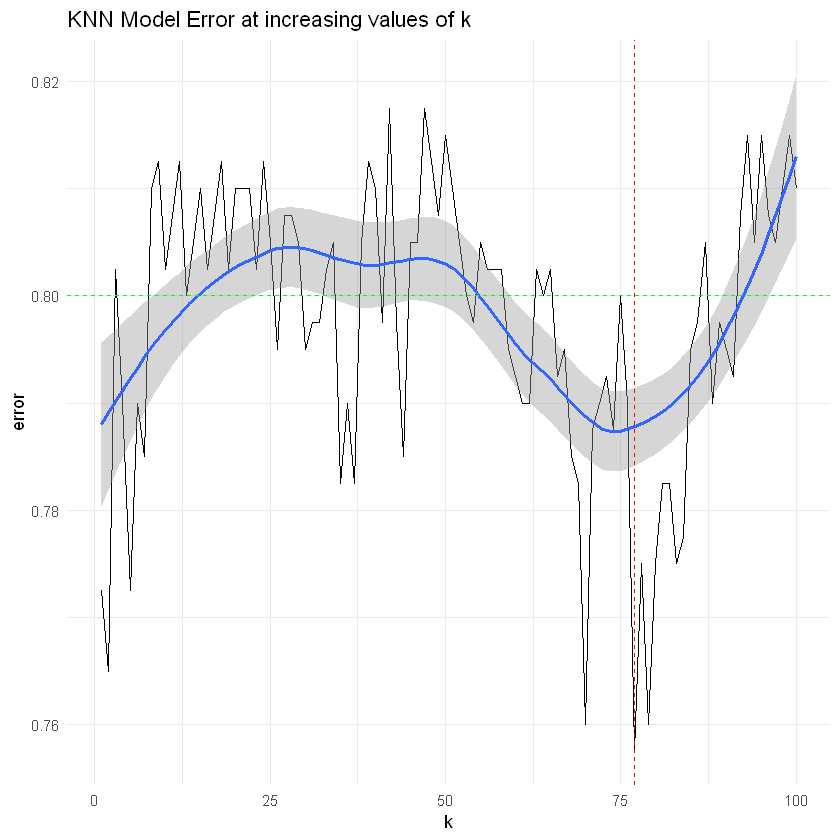

In [381]:
# determine the optimal value of k based on model error
optimal_k <- which.min(k_table$error)
print(paste(optimal_k,k_table$error[optimal_k]))

# plot the differences in model performance across values of k
ggplot(k_table, aes(x=k,y=error)) +
    geom_line() + 
    geom_smooth() +
    theme_minimal() +
    geom_vline(xintercept=optimal_k,linetype='dashed',color='red') +
    geom_hline(yintercept=0.8,linetype='dashed',color='green') +
    labs(title='KNN Model Error at increasing values of k', x='k', y='error')

##### 5.1.2: Conclusion

Overall, the optimal value of k seems to be 77 (red dashed line), though the associated model error is still 0.7625 or 76.25%, which is essentially chance performance for 5-way classification (green dashed line). The failure of KNN to properly classify the observations is likely due to KNN's strong sensitivity to model dimensionality.

The fact that we have 201 variables and 400 observations could suggest that our KNN model has fallen prey to the 'curse of dimensionality', which essentially states that as p -> n, the model does not have sufficient neighbors to query in order to generate a prediction. This leads to high test set errors as observed in the above figure.

There are multiple methods of remediating high dimensionality in models. In the following subsections, we will apply both principal components methods and sparsity constraints to reduce the model dimensionality and hopefully improve decoding performance.

#### 5.2: Dimensionality Reduction

##### 5.2.1 Content

Given the results of the KNN, it is likely that our model is overparameterized. One way of addressing high model dimensionality is principal components analysis (PCA). In PCA, we learn a set of component loadings *phi* that project our data into a lower dimensional subspace while retaining as much of the variability in the data as possible.

We begin by examining the correlational structure in the time series. Note that only a subset of the 200 variables are shown to make local effects clearer.

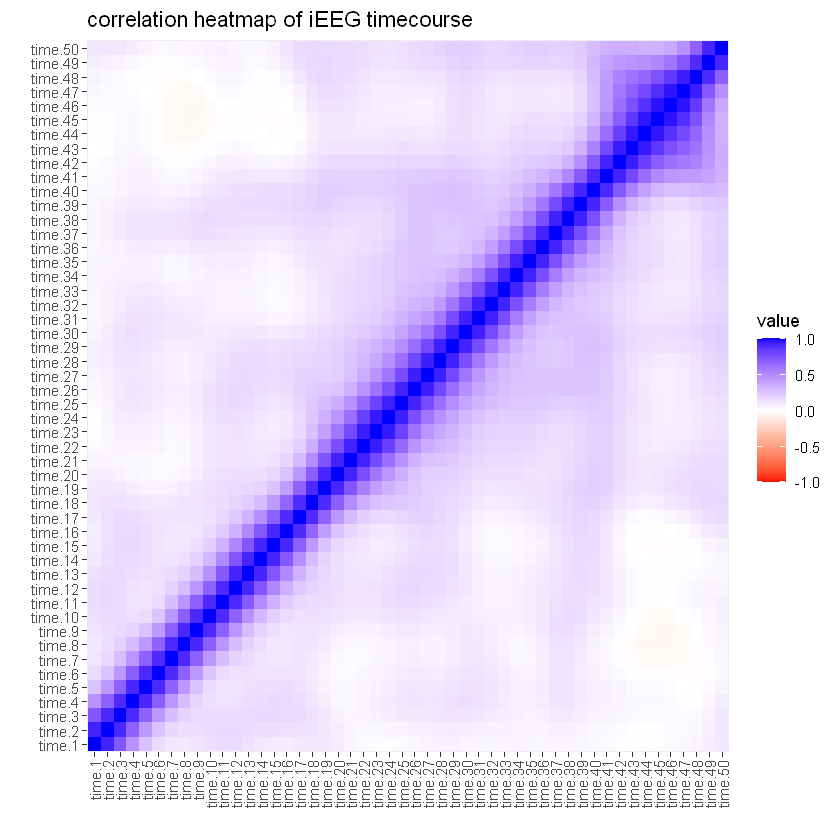

In [382]:
# generate correlation matrix for a subset the time series
cor_timeseries <- cor(X_train[,1:50])

# convert from wide to long format
cor_timeseries <- melt(cor_timeseries)

# visualize the correlational structure of the timeseries
correlogram <- ggplot(cor_timeseries, aes(x=Var1,y=Var2, fill=value)) +
  geom_tile() +
  scale_x_discrete(guide = guide_axis(angle = 90)) +
  scale_fill_gradient2(low='red',high='blue',limits = c(-1, 1)) +
  labs(title='correlation heatmap of iEEG timecourse', x='', y='')

correlogram

Based on the correlogram, it seems that the primary structure in the time-series is that time-points are strongly correlated with nearby timepoints, with heavily reduced correlation with more distant time points. 

Next, we examine how many principal components are necessary to explain 95% of our data.

[1] 50

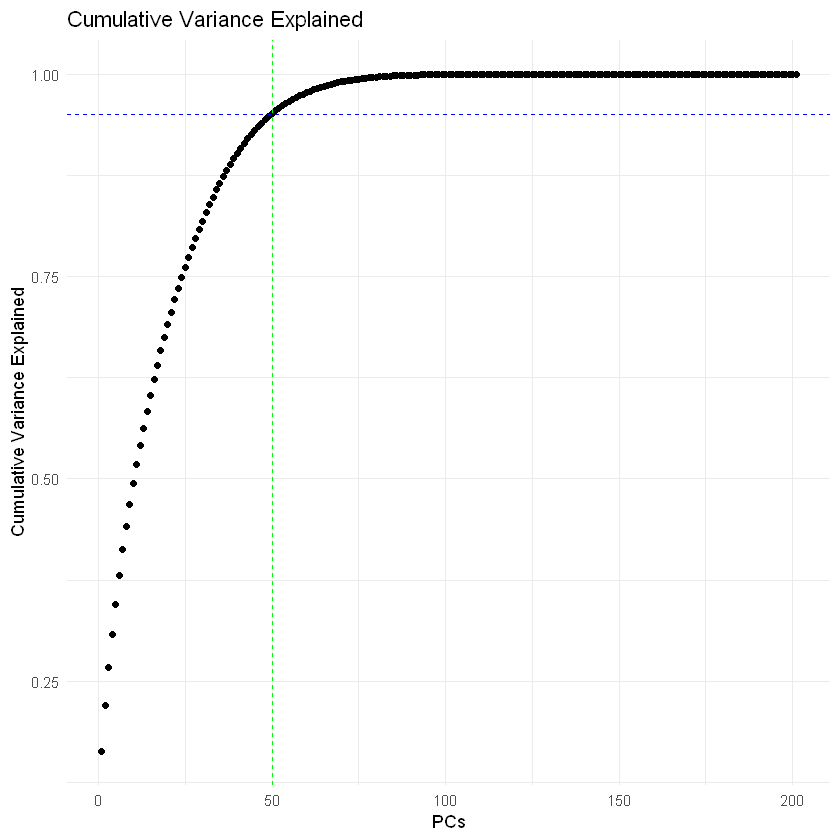

In [383]:
# perform PCA on neural timeseries
timeseries.pca <- princomp(X_train, cor = TRUE)
timeseries.pca.out <- summary(timeseries.pca)

# examine cumulative variance explained
cum_var_exps <- cumsum(timeseries.pca.out$sdev^2 / sum(timeseries.pca.out$sdev^2))

# calculate how many PCs are needed to explain 95% of variance
threshold_pcs <- min(which(cum_var_exps > 0.95))
threshold_pcs

# plot cumulative variance explained
ggplot(data.frame(x=seq(length(cum_var_exps)), y=cum_var_exps), aes(x, y)) +
  geom_point() +
  geom_hline(yintercept = 0.95, linetype='dashed', color='blue') +
  geom_vline(xintercept = threshold_pcs, linetype='dashed', color='green') +
  theme_minimal() +
  labs(title='Cumulative Variance Explained',x='PCs',y='Cumulative Variance Explained')

Based on the above figure, the minimum number of principal components required to explain 95% of the variance appears to be 50. This is a major reduction in model dimensionality compared to 202, which may help to ameliorate model performance.

We are now able to perform Principal Components Regression (PCR) on our data, predicting stimulus category from the 50 components that explain 95% of the data.

[1] 8

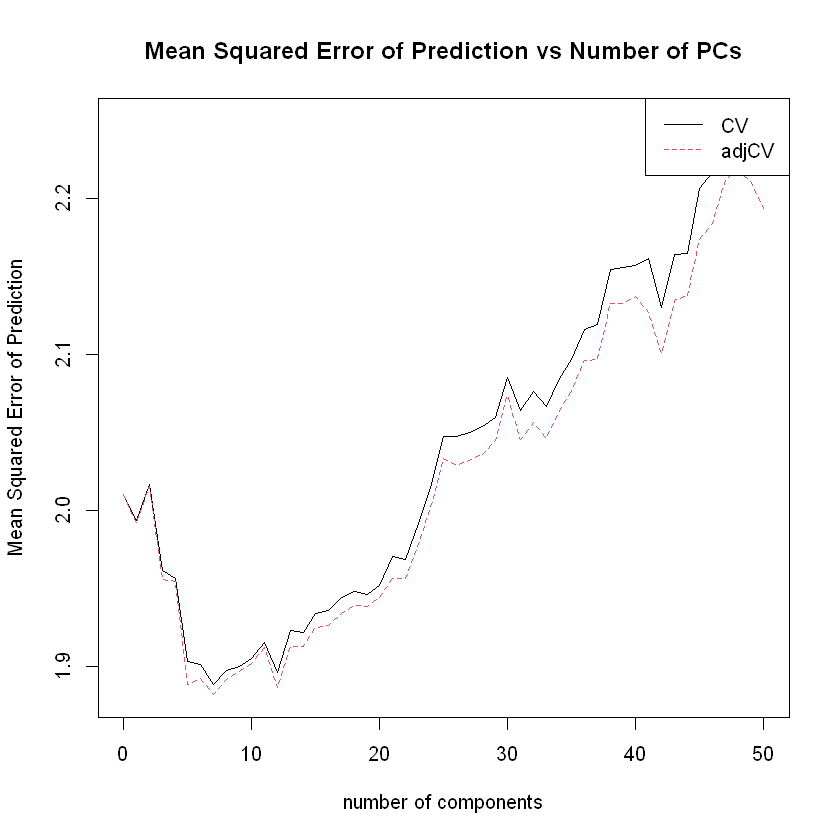

In [386]:
# Adjust Y_train to be numeric for PCR
train_data_pcr <- train_data
train_data_pcr$label <- as.numeric(as.factor(train_data_pcr$label))

# Fit PCR model to the data
pcr.fit <- pcr(label~., data=train_data_pcr, scale = TRUE, ncomp = 50, validation="CV")

# plot mean squared error of prediction against number of PCs
validationplot(pcr.fit, val.type="MSEP", ylab = "Mean Squared Error of Prediction", 
              main = "Mean Squared Error of Prediction vs Number of PCs",
              legend = 'topright') # use mean squared error

# extract CV MSEP values
mseps <- MSEP(pcr.fit, estimate = "CV") # only cross validated MSEP values
mseps <- drop(mseps) # remove singleton dimension

# find no. of PCs with minimum CV MSEP
min_msep <- which.min(mseps[[1]])
min_msep

Based on the MSEP plot above, it seems that 7 components best explain the variance in stimulus category. The fact that this number is lower than the number of PCs necessary to reach 95% of variance in X suggests that there is a large degree of variability in the timeseries that is unrelated to stimulus category. 

Finally, we use the fitted PCR to predict our test set.

In [387]:
# train PCR model using number of PCs that explain 95% of variance
pcr_model <- pcr(label~., data=train_data_pcr, scale = TRUE, ncomp = 7)

# predict test set from fitted model
preds <- predict(pcr_model, newdata = X_test, ncomp = 7)
preds_factor <- factor(round(preds), levels=c(1,2,3,4,5), labels=c("boat","camera","car","guitar","lamp"))

# print confusion matrix
confusionMatrix(preds_factor,as.factor(Y_test))

Confusion Matrix and Statistics

          Reference
Prediction boat camera car guitar lamp
    boat      0      0   0      0    0
    camera    2      2   1      1    1
    car      17     15  16     17   16
    guitar    1      3   3      2    3
    lamp      0      0   0      0    0

Overall Statistics
                                          
               Accuracy : 0.2             
                 95% CI : (0.1267, 0.2918)
    No Information Rate : 0.2             
    P-Value [Acc > NIR] : 0.5398          
                                          
                  Kappa : 0               
                                          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: boat Class: camera Class: car Class: guitar
Sensitivity                  0.0        0.1000     0.8000        0.1000
Specificity                  1.0        0.9375     0.1875        0.8750
Pos Pred Value               NaN        0.2857     0.1975        0.

##### 5.2.2: Conclusion

Based on the confusion matrix, we again see that our model accuracy is essentially at chance performance. Puzzlingly, the model seems to heavily favor predicting cars compared to the other stimulus categories. This seems to suggest that the latent features that are picked up by the PCA overwhelmingly bias the model towards predicting cars.

#### 5.3: Regularized Classification (LASSO)

##### 5.3.1: Content

While PCA methods do reduce the dimensionality of models, they still rely on the entire set of features to generate the lower dimensional subspace. Sparsity constraint measures, such as regularized regression instead adjust the traditional linear regression approach with a penalty to 'weak' effects. LASSO regression applies a shrinkage penalty that can shrink weak coefficients all the way to 0, essentially selecting the 'best' of a set of correlated features X, like our timeseries.

First, we fit a `cv.glmnet` function with `alpha` set to 1 to perform LASSO regression. This performs LASSO over a range of values for the sparsity parameter *lambda*, which allows us to find the optimal value for use in the final model.

In [388]:
# convert variable types to conform with glmnet
Y_train_glmnet <- factor(Y_train)
Y_test_glmnet <- factor(Y_test)
X_train_glmnet <- as.matrix(X_train)
X_test_glmnet <- as.matrix(X_test)

# perform cross-validated LASSO to find optimal sparsity parameter lambda
cv_glm_fit <- cv.glmnet(X_train_glmnet, Y_train_glmnet, family = "multinomial", alpha = 1)

# extract optimal value for lambda
lambda <- cv_glm_fit$lambda.min
lambda

[1] 0.03494823

In [389]:
# fit a LASSO regression with the optimal sparsity parameter
LASSO_fit <- glmnet(X_train_glmnet, Y_train_glmnet, family = 'multinomial', alpha = 1, lambda = lambda)

# predict test set using fitted LASSO
glmnet_preds <- predict(LASSO_fit, newx = X_test_glmnet, s = lambda, type = 'class')

# print confusion matrix
confusionMatrix(Y_test_glmnet,as.factor(glmnet_preds))

Confusion Matrix and Statistics

          Reference
Prediction boat camera car guitar lamp
    boat      2      4   4      8    2
    camera    3      6   4      6    1
    car       4      6   1      5    4
    guitar    3      7   2      3    5
    lamp      6      1   2      8    3

Overall Statistics
                                          
               Accuracy : 0.15            
                 95% CI : (0.0865, 0.2353)
    No Information Rate : 0.3             
    P-Value [Acc > NIR] : 0.9998          
                                          
                  Kappa : -0.0625         
                                          
 Mcnemar's Test P-Value : 0.6739          

Statistics by Class:

                     Class: boat Class: camera Class: car Class: guitar
Sensitivity               0.1111        0.2500    0.07692        0.1000
Specificity               0.7805        0.8158    0.78161        0.7571
Pos Pred Value            0.1000        0.3000    0.05000        0.

##### 5.3.2: Conclusion

Similarly to the PCR model, the LASSO model does not seem to be able to predict stimulus category from the regularized timeseries, failing to even reach chance accuracy. Unlike the PCR, the confusion matrix from the LASSO does not seem to favor a particular class. This seems to suggest that even with weak effects forced out of the model, the 'best' set of variables is not predictive of stimulus category.

---

### 6. Conclusions

None of the three approaches tested were able to decode stimulus category from the iEEG timecourses in dorsal cortex. This failure to replicate the findings in (Ayzenberg & Behrmann, 2022) could be due to a number of different factors. 

1. It could be the case that an error or set of errors was made in the preprocessing of the data. The process of collecting and processing iEEG data involves a large number of steps, and even a small mistake (such as poor referencing or using incorrect timing information) can confound any further analysis of the data. 
2. The 16 electrode contacts examined in this study are a sample of the total 162. These electrodes were selected due to their positioning in dorsal cortex, but it is entirely possible that the electrodes have been mislocalized. The process of localizing intracranial electrodes in space is done manually with documentation from the neurology team. If the data is incorrect or corrupted, it is entirely possible that these electrodes are actually located in cortex that is not visually responsive.
3. It is also possible that these electrodes are not mislocalized and that dorsal cortex as reflected in iEEG activity does not support category discrimination. The purpose of re-examining fMRI findings with high-resolution electrophysiological data is to test prior theory at a finer scale.

This analysis is by no means a final answer to whether or not dorsal cortex plays a role in object recognition. Further analyses of all electrodes within this patient and analyses across multiple patients may reveal effects that were not observable within the context of this data. Improving our nderstanding the roles of dorsal and ventral cortex in facilitating object recognition helps visual neuroscience researchers along the path to understanding how our cognitive abilities are realized in the brain.

---

### 7. References

1. Ayzenberg, V., &amp; Behrmann, M. (2022). The dorsal visual pathway represents object-centered spatial relations for object recognition. The Journal of Neuroscience, 42(23), 4693–4710. https://doi.org/10.1523/jneurosci.2257-21.2022 
2. Bracci, S., &amp; Op de Beeck, H. (2016). Dissociations and associations between shape and category representations in the two visual pathways. The Journal of Neuroscience, 36(2), 432–444. https://doi.org/10.1523/jneurosci.2314-15.2016 
3. Freud, E., Culham, J. C., Plaut, D. C., &amp; Behrmann, M. (2017). The large-scale organization of shape processing in the ventral and dorsal pathways. ELife, 6. https://doi.org/10.7554/elife.27576 
4. Magnotti, J. F., Wang, Z., &amp; Beauchamp, M. S. (2020). Rave: Comprehensive open-source software for reproducible analysis and visualization of intracranial EEG data. NeuroImage, 223, 117341. https://doi.org/10.1016/j.neuroimage.2020.117341 
5. Mishkin, M., Ungerleider, L. G., &amp; Macko, K. A. (1983). Object vision and spatial vision: Two cortical pathways. Trends in Neurosciences, 6, 414–417. https://doi.org/10.1016/0166-2236(83)90190-x 
6. Ungerleider, L. (1994). 'what' and 'where' in the human brain. Current Opinion in Neurobiology, 4(2), 157–165. https://doi.org/10.1016/0959-4388(94)90066-3 